# Image Classification on Fashion MNIST with TensorFlow-Quantum and Cirq

## 1. Installing required packages

In [1]:
# !pip install tensorflow-gpu==2.1.0
# !pip install cirq-google==0.13.1 cirq==0.7.0 pathos==0.2.5 tensorflow-quantum==0.4.0
!pip install cirq==0.13.1 tensorflow-quantum==0.6.0 tensorflow==2.7.0 

     |████████████████████████████████| 10.5 MB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 489.6 MB 17 kB/s s eta 0:00:01    |█████▏                          | 79.2 MB 77.5 MB/s eta 0:00:06
     |████████████████████████████████| 328 kB 42.0 MB/s eta 0:00:01
     |████████████████████████████████| 437 kB 60.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 3.5 MB/s  eta 0:00:01
     |████████████████████████████████| 55 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 1.6 MB 58.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 463 kB 62.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 24.5 MB 68.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 25.9 MB/s eta 0:00:01
     |████████████████████████████

## 2. Importing required packages

In [2]:
import tensorflow as tf

# Data Processing tools
import numpy as np
from sklearn.model_selection import train_test_split 
import math
from sklearn.decomposition import PCA

# Qauntum Related Libraries 
import cirq
import sympy
import tensorflow_quantum as tfq

# Visualization Tools
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import tensorflow_datasets as tfds
import time

# np.random.seed(1234)

In [3]:
# Lets print the version of cirq and tfq that we will use
print("We are using the TensorFlow-Quantum version {}".format(tfq.__version__))
print("We are using the Cirq version {}".format(cirq.__version__))
print("We are using TF version {}".format(tf.__version__)) 

We are using the TensorFlow-Quantum version 0.6.0
We are using the Cirq version 0.13.1
We are using TF version 2.7.0


In [4]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  []


# 3. Data preparation

## 3.1 Import Dataset

Below we will download the Fashion MNIST dataset from keras datasets

In [5]:
# Importing the Fashion MNIST dataset from keras
from tensorflow.keras.datasets import fashion_mnist as dataset

# x_train and x_test are the images and y_train and y_test are the labels.
(x_train, y_train), (x_test, y_test) = dataset.load_data()

4431872/4422102 [==============================] - 1s 0us/step


## 3.2 Data Exploration
We will explore our dataset below in order to identify what sort of pre-processing is required before we reach our model development.

We start by checking how the images looks like in the dataset and how many samples do we have in each class

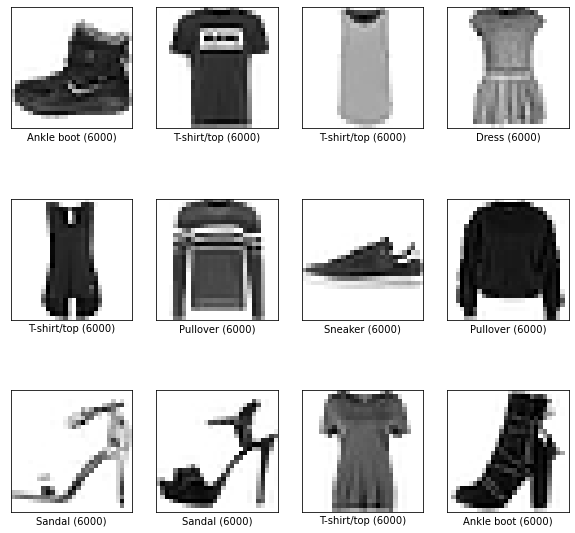

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get total count
unique, counts = np.unique(y_train, return_counts=True)

# Plot the first 12 images from the dataset along with count next to class name
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(f"{class_names[y_train[i]]} ({counts[y_train[i]]})")
plt.show()

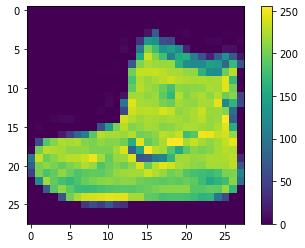

In [7]:
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [8]:
# Scaling the data so that the pixel values are between 0.0 and 1.0 from 0 to 255.
x_train = x_train / 250.0
x_test = x_test / 250.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [9]:
# x and y are the images and labels of the fashion MNIST dataset.
def dataFilteration(x, y):
    # Keep samples where y equals 5 (Sandal) or 7 (Sneaker)
    keep = (y == 5) | (y == 7)
    # Filter x and y based on the condition defined by keep
    x, y = x[keep], y[keep]
    # Convert y labels to binary values: True if y is 0, False otherwise
    y = y == 0
    # Return filtered x and binary labels y
    return x, y

In [10]:
# Filter training data and print the number of filtered training examples
x_train, y_train = dataFilteration(x_train, y_train)
print("Number of filtered training examples:", len(x_train))

# Filter test data and print the number of filtered test examples
x_test, y_test = dataFilteration(x_test, y_test)
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


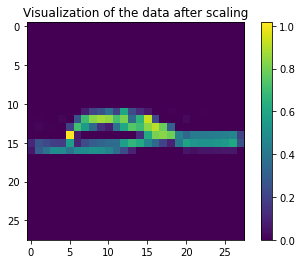

In [11]:
#Let's again have a look at the first image from our X_train and
#see if we have successfully normalized the datasets
plt.imshow(x_test[0])
plt.colorbar()
plt.title('Visualization of the data after scaling')
plt.show()

New datapoint dimension: 10


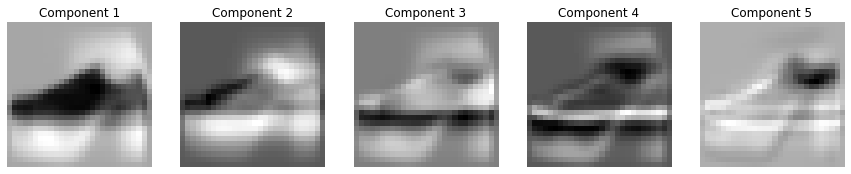

In [12]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Define a function to visualize principal components as images
def visualize_principal_components(pca_components, num_components_to_visualize, image_shape):
    fig, axes = plt.subplots(1, num_components_to_visualize, figsize=(15, 3))
    for i in range(num_components_to_visualize):
        component_image = pca_components[i].reshape(image_shape)
        axes[i].imshow(component_image, cmap='gray')
        axes[i].set_title(f'Component {i+1}')
        axes[i].axis('off')
    plt.show()

def apply_pca(x_train, x_test, n_components):
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train.reshape(-1, 28*28))
    x_test_pca = pca.transform(x_test.reshape(-1, 28*28))
    return x_train_pca, x_test_pca, pca

# Assuming x_train and x_test are already defined and contain your dataset

DATASET_DIM = 10  # Define the desired dimensionality of the dataset

# Apply PCA to reduce dimensionality of training and test datasets
x_train, x_test, pca = apply_pca(x_train, x_test, n_components=DATASET_DIM)

# Print the dimensionality of the new datapoints
print(f'New datapoint dimension:', len(x_train[0]))

# Visualize the first few principal components as images
num_components_to_visualize = 5
visualize_principal_components(pca.components_, num_components_to_visualize, image_shape=(28, 28))

In [13]:
N_TRAIN = 1000  # Number of samples to keep in the training set
N_TEST = 200   # Number of samples to keep in the test set

# Select the first N_TRAIN samples from the training set
x_train, y_train = x_train[:N_TRAIN], y_train[:N_TRAIN]

# Select the first N_TEST samples from the test set
x_test, y_test = x_test[:N_TEST], y_test[:N_TEST]

In [14]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 200


In [15]:
def single_qubit_wall(qubits, rotations):
    """
    Prepare a single-qubit X, Y, Z rotation wall on `qubits`.

    Args:
    - qubits: A list of qubits on which the rotation wall is applied.
    - rotations: A list of lists representing the rotation angles for each qubit and each rotation (X, Y, Z).

    Returns:
    - wall_circuit: The constructed quantum circuit representing the rotation wall.
    """

    wall_circuit = cirq.Circuit()  # Initialize an empty quantum circuit to hold the rotation wall

    # Iterate over each qubit and its corresponding rotation angles
    for i, qubit in enumerate(qubits):
        # Iterate over X, Y, Z rotations
        for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
            # Apply the rotation gate to the current qubit with the specified rotation angle
            wall_circuit.append(gate(qubit) ** rotations[i][j])

    return wall_circuit  # Return the constructed quantum circuit

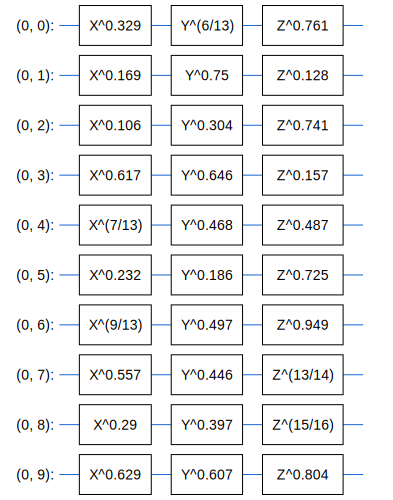

In [16]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,10), np.random.uniform(size=(10, 3))))

In [17]:
def v_theta(qubits):
    """
    Prepares a circuit that generates V(\theta).

    Args:
    - qubits: A list of qubits on which the V(\theta) operator will be applied.

    Returns:
    - v_theta_circuit: The constructed quantum circuit representing V(\theta).
    - exp_symbols: A list of symbols representing the exponents of the exponential gates.
    """

    ref_paulis = [
        # Constructing the tensor product of Pauli operators for neighboring qubits
        cirq.X(q0) * cirq.X(q1) + \
        cirq.Y(q0) * cirq.Y(q1) + \
        cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
    ]

    # Generating symbols for the exponents of the exponential gates
    exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))

    # Constructing the V(\theta) circuit using exponential gates with the generated symbols
    v_theta_circuit = tfq.util.exponential(ref_paulis, exp_symbols)

    return v_theta_circuit, exp_symbols  # Returning the V(\theta) circuit and the symbols for the exponents

Symbols found in circuit:[ref_0, ref_1, ref_2, ref_3, ref_4, ref_5, ref_6, ref_7, ref_8]


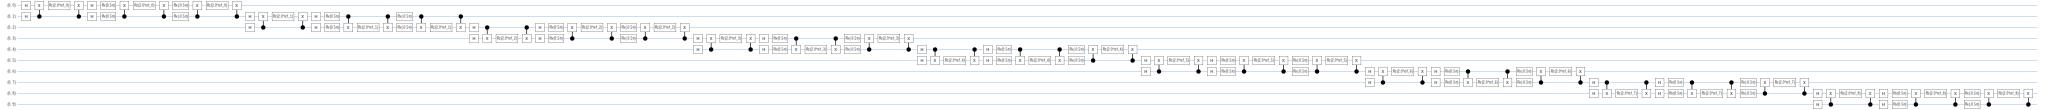

In [18]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 10))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

In [19]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
    """
    Prepare the pqk feature circuits around a dataset.

    Args:
    - qubits: A list of qubits to be used in the circuits.
    - classical_source: A list or array of classical values to be used as sources for parameterizing the circuits.
    - n_trotter: Number of Trotter steps to use for the parameterized V circuit. Default is 10.

    Returns:
    - full_circuits: Tensor containing the prepared pqk feature circuits.
    """

    n_qubits = len(qubits)  # Number of qubits
    n_points = len(classical_source)  # Number of data points

    # Prepare a random single qubit rotation wall
    random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
    initial_U = single_qubit_wall(qubits, random_rots)

    # Prepare parametrized V circuit
    V_circuit, symbols = v_theta(qubits)
    exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

    # Convert initial_U to `tf.Tensor`
    initial_U_tensor = tfq.convert_to_tensor([initial_U])
    initial_U_splat = tf.tile(initial_U_tensor, [n_points])

    # Concatenate initial_U_splat with exp_circuit
    full_circuits = tfq.layers.AddCircuit()(
        initial_U_splat, append=exp_circuit)
    
    # Replace placeholders in circuits with values from `classical_source`
    return tfq.resolve_parameters(
        full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
        tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))


In [20]:
# Define qubits using a grid layout
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)

# Prepare pqk feature circuits for the training dataset
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)

# Prepare pqk feature circuits for the test dataset
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

In [21]:
def get_pqk_features(qubits, data_batch):
    """
    Get PQK features based on the construction of Pauli operators.

    Args:
    - qubits: A list of qubits.
    - data_batch: A batch of quantum data.

    Returns:
    - rdm: The reduced density matrix (RDM) representing the PQK features.
    """

    # Define Pauli operators (X, Y, Z) for each qubit
    ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]

    # Convert Pauli operators to a tensor and expand dimensions
    ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)

    # Tile the Pauli operator tensor to match the batch size
    batch_dim = tf.gather(tf.shape(data_batch), 0)
    ops_splat = tf.tile(ops_tensor, [batch_dim, 1])

    # Compute expectation values of Pauli operators for the data batch
    exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)

    # Reshape the expectation values to match the batch size and number of qubits
    rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])

    return rdm

In [22]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


# Relabeling

In [23]:
def compute_kernel_matrix(vecs, gamma):
    """Computes the Gaussian kernel matrix."""
    # Compute scaled gamma based on the standard deviation of the vectors
    scaled_gamma = gamma / (tf.cast(tf.shape(vecs)[1], tf.float32) * tf.math.reduce_std(vecs))
    
    # Compute pairwise squared Euclidean distances and apply Gaussian kernel
    pairwise_distances_sq = tf.reduce_sum((vecs[:, None, :] - vecs) ** 2, axis=-1)
    kernel_matrix = scaled_gamma * tf.exp(-pairwise_distances_sq)
    
    return kernel_matrix

def get_spectrum(datapoints, gamma=1.0):
    """Compute the eigenvalues and eigenvectors of the kernel matrix."""
    # Compute the kernel matrix
    kernel_matrix = compute_kernel_matrix(datapoints, gamma)
    
    # Compute eigenvalues and eigenvectors
    S, V = tf.linalg.eigh(kernel_matrix)
    
    # Take absolute values of eigenvalues
    S = tf.abs(S)
    
    return S, V

In [24]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[-0.00100413  0.00018794  0.00991504 ...  0.00498782 -0.00673942
   0.03268122]
 [ 0.00257935  0.00652642 -0.0005751  ... -0.01323881 -0.00469063
   0.02403906]
 [ 0.00126685  0.01287545 -0.01286369 ...  0.03994881 -0.01724382
   0.05464377]
 ...
 [-0.00020261  0.00108716  0.00094089 ...  0.01717531  0.08706384
   0.01735103]
 [ 0.00634143 -0.00192539  0.00320628 ...  0.0134436   0.10997786
   0.02113574]
 [ 0.000467   -0.00110836 -0.00224872 ...  0.00566399  0.05507725
   0.00642862]], shape=(1200, 1200), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[-7.2643161e-08  1.2555945e-05  2.2720205e-07 ...  2.7812280e-02
  -7.4900333e-07  3.0380688e-04]
 [-1.9516847e-08 -3.0815269e-08 -4.1378595e-08 ... -3.4497123e-08
  -4.1931933e-08  8.1450429e-09]
 [-2.0464972e-08  2.0312765e-08 -8.0724961e-11 ... -5.9521909e-08
   3.4726721e-09 -1.4333954e-08]
 ...
 [ 4.9786564e-16  4.6781968e-16  1.4143252e-15 ... -2.5398683e-17
  -5.15

In [25]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
    """
    Prepare new labels that maximize geometric distance between kernels.

    Args:
    - S: Eigenvalues of the first kernel matrix.
    - V: Eigenvectors of the first kernel matrix.
    - S_2: Eigenvalues of the second kernel matrix.
    - V_2: Eigenvectors of the second kernel matrix.
    - lambdav: Scaling parameter for adjusting the second kernel matrix. Default is 1.1.

    Returns:
    - noisy_y: New labels with added noise.
    """

    # Compute diagonal matrices from eigenvalues
    S_diag = tf.linalg.diag(S ** 0.5)
    S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
    
    # Compute scaling matrix
    scaling = S_diag @ tf.transpose(V) @ V_2 @ S_2_diag @ tf.transpose(V_2) @ V @ S_diag

    # Generate new labels using the largest eigenvector
    _, vecs = tf.linalg.eig(scaling)
    new_labels = tf.math.real(
        tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()

    # Create new labels and add some small amount of noise
    final_y = new_labels > np.median(new_labels)
    noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
    
    return noisy_y

In [26]:
# Obtain new labels based on the spectrum of kernel matrices
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)

# Split new labels into training and test sets
y_train_new, y_test_new = y_relabel[:N_TRAIN], y_relabel[N_TRAIN:]

# Comparing models

In [27]:
# Define a function to create model
def QC_NN(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=input_shape))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [28]:
input_shape = [len(qubits) * 3,]

# Create the pqk model
pqk_model = QC_NN(input_shape)

# Compile the model with binary crossentropy loss and Adam optimizer
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

# Display model summary
# pqk_model.summary()
q_start_training = time.time()
# Fit the pqk model to the training data
pqk_history = pqk_model.fit(
    tf.reshape(x_train_pqk, [N_TRAIN, -1]),  # Reshape the pqk features for training
    y_train_new,  # New labels for training
    batch_size=32,  # Batch size for training
    epochs=1000,  # Number of epochs for training
    verbose=0,  # Suppress training progress output
    validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new)  # Validation data
)
q_end_training = time.time()

print("Time taken for training: {} seconds".format(q_end_training - q_start_training))

Time taken for training: 76.60829782485962 seconds


In [29]:
input_shape = [DATASET_DIM,]
model = QC_NN(input_shape)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

# model.summary()

c_start_training = time.time()
# Fit the classical model to the training data
classical_history = model.fit(
    x_train,  # Original dataset features for training
    y_train_new,  # New labels for training
    batch_size=32,  # Batch size for training
    epochs=1000,  # Number of epochs for training
    verbose=0,  # Suppress training progress output
    validation_data=(x_test, y_test_new)  # Validation data
)
c_end_training = time.time()
print("Time taken for training: {} seconds".format(c_end_training - c_start_training))

Time taken for training: 81.80575942993164 seconds


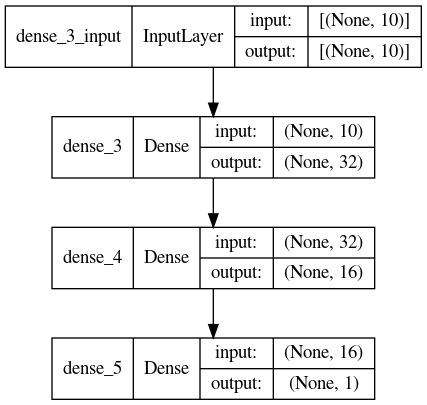

In [30]:
# Param Configurations
strucutre = "TB" # Model plot top-to-bottom
classesInDataset = 2
modelPlotDensity = 96

# Model visualization
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True, rankdir=strucutre, expand_nested=True, dpi=modelPlotDensity
)

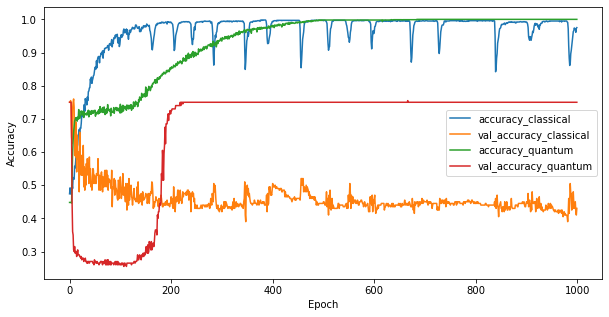

In [31]:
# Create a figure for plotting
plt.figure(figsize=(10, 5))

# Plot training and validation accuracies for the classical model
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')

# Plot training and validation accuracies for the pqk model
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [32]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train_new, verbose=0, steps=math.ceil(10000/32))
_, test_acc = model.evaluate(x_test, y_test_new, verbose=0, steps=math.ceil(10000/32))
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

_, train_acc = pqk_model.evaluate(tf.reshape(x_train_pqk, [N_TRAIN, -1]), y_train_new, verbose=0, steps=math.ceil(10000/32))
_, test_acc = pqk_model.evaluate(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new, verbose=0, steps=math.ceil(10000/32))
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

Train accuracy: 0.9700000286102295
Test accuracy: 0.4300000071525574
Train accuracy: 1.0
Test accuracy: 0.75


In [33]:
# validation accuracy and epoch
trace1 = go.Scatter(x=classical_history.epoch, y=classical_history.history['val_accuracy'], mode='lines', name='classical_val')
trace2 = go.Scatter(x=pqk_history.epoch, y=pqk_history.history['val_accuracy'], mode='lines', name='quantum_val')

layout = go.Layout(title='Validation Accuracy', xaxis=dict(title='Epoch'), yaxis=dict(title='Accuracy'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


In [34]:
# validation accuracy and epoch also add tip for the best epoch
trace1 = go.Scatter(x=classical_history.epoch, y=classical_history.history['val_accuracy'], mode='lines', name='classical_val')
trace2 = go.Scatter(x=pqk_history.epoch, y=pqk_history.history['val_accuracy'], mode='lines', name='quantum_val')
# best epoch for classical model
best_epoch_classical = np.argmax(classical_history.history['val_accuracy'])
trace3 = go.Scatter(x=[best_epoch_classical], y=[classical_history.history['val_accuracy'][best_epoch_classical]], mode='markers', name='best_epoch_classical', marker=dict(size=10))
# best epoch for quantum model
best_epoch_quantum = np.argmax(pqk_history.history['val_accuracy'])
trace4 = go.Scatter(x=[best_epoch_quantum], y=[pqk_history.history['val_accuracy'][best_epoch_quantum]], mode='markers', name='best_epoch_quantum', marker=dict(size=10))

layout = go.Layout(title='Validation Accuracy', xaxis=dict(title='Epoch'), yaxis=dict(title='Accuracy'))
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()




In [35]:
import plotly.subplots as sp

# Create subplots (2 rows, 1 column)
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Classical Model", "Quantum Model"))

# Add traces to the subplots
fig.add_trace(go.Scatter(
    x=classical_history.epoch,
    y=classical_history.history['val_accuracy'],
    mode='lines', 
    name='classical_val'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=pqk_history.epoch,
    y=pqk_history.history['val_accuracy'],
    mode='lines',
    name='quantum_val'
), row=1, col=2)

# Best Epoch Logic
best_epoch_classical = np.argmax(classical_history.history['val_accuracy'])
best_epoch_quantum = np.argmax(pqk_history.history['val_accuracy'])

fig.add_trace(go.Scatter(
    x=[best_epoch_classical], 
    y=[classical_history.history['val_accuracy'][best_epoch_classical]],
    mode='markers', 
    name='best_epoch_classical', 
    marker=dict(size=10)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=[best_epoch_quantum], 
    y=[pqk_history.history['val_accuracy'][best_epoch_quantum]],
    mode='markers', 
    name='best_epoch_quantum',
    marker=dict(size=10)
), row=1, col=2)

# Add final accuracy tips
final_accuracy_classical = classical_history.history['val_accuracy'][-1]
final_accuracy_quantum = pqk_history.history['val_accuracy'][-1]

fig.update_layout(
    height=400,  
    showlegend=False,  
    annotations=[
        dict(text=f"Classical Accuracy: {final_accuracy_classical:.2f}%", x=0.1, xref="paper", y=1.1, yref="paper", showarrow=False),
        dict(text=f"Quantum Accuracy: {final_accuracy_quantum:.2f}%", x=0.9, xref="paper", y=1.1, yref="paper", showarrow=False),
    ]
)

fig.show()


Test Loss: 0.06865929812192917
Test Accuracy: 0.9700000286102295
Confusion Matrix:
[[437  11]
 [ 19 533]]
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97       448
        True       0.98      0.97      0.97       552

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



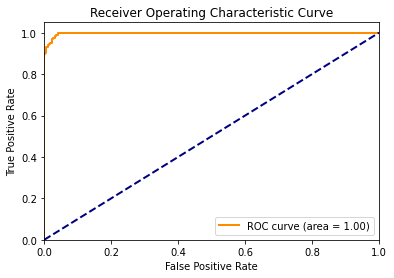

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define the evaluation function
def evaluate_model(model, x_test, y_test):
    # Evaluate the model
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print("Test Loss:", loss)
    print("Test Accuracy:", acc)

    # Predictions
    predictions = model.predict(x_test)
    binary_predictions = (predictions > 0.5).astype("int32")

    # Confusion matrix
    confusion = confusion_matrix(y_test, binary_predictions)
    print("Confusion Matrix:")
    print(confusion)

    # Classification report
    report = classification_report(y_test, binary_predictions)
    print("Classification Report:")
    print(report)

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
evaluate_model(model,x_train, y_train_new)

## Refernces

* https://quantumai.google/cirq/tutorials
* [Paper by Farhi et al.](https://arxiv.org/pdf/1802.06002.pdf)
* [Paper by Dmitri Maslov](https://www.google.com/url?sa=t&source=web&rct=j&url=https://arxiv.org/pdf/1603.07678&ved=2ahUKEwi86KbBlfvuAhUmzDgGHfteCIsQFjAJegQIHhAC&usg=AOvVaw04beRgWLMZhYBV6GpyygHF)